In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
#from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


In [2]:
df1=pd.read_csv("./processed/training/engaged.csv")
df2=pd.read_csv("./processed/training/notEngaged.csv")
dff=pd.read_csv("./TopFeatures.csv")

In [3]:
dft=pd.concat([df1,df2])

In [4]:
feat=dff.to_numpy()
feat=feat.reshape(-1)

In [5]:
y_train=dft["Result"]
x_train=dft.drop("Result",axis=1)

In [6]:
x_train=x_train[feat]

In [7]:
# compute required values
scaler = StandardScaler()
model = scaler.fit(x_train)
x_train = model.transform(x_train)

In [8]:
model = LogisticRegression(max_iter=2000,class_weight="balanced")

In [9]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
   
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt



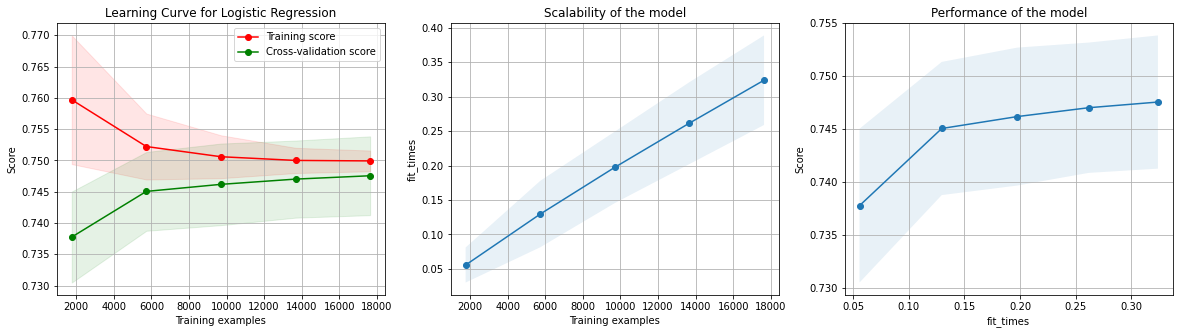

In [10]:
#fig, axes = plt.subplots(3, 1, figsize=(10, 15))


title = "Learning Curve for Logistic Regression"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = model
plot_learning_curve(estimator, title, x_train, y_train,
                    cv=cv, n_jobs=4)

plt.show()

In [11]:
avg_score=cross_val_score(model,x_train, y_train, cv=100)

In [12]:
print(avg_score)
print(sum(avg_score)/100)

[0.760181   0.80090498 0.76470588 0.75565611 0.81447964 0.75113122
 0.81447964 0.82352941 0.78733032 0.84162896 0.78280543 0.77828054
 0.80090498 0.85067873 0.83257919 0.76470588 0.85520362 0.86877828
 0.81447964 0.79638009 0.74660633 0.87782805 0.7918552  0.58823529
 0.70135747 0.45248869 0.60180995 0.57918552 0.62895928 0.62895928
 0.58823529 0.58823529 0.58823529 0.65158371 0.57013575 0.64705882
 0.47963801 0.61085973 0.60180995 0.49321267 0.49321267 0.58823529
 0.50678733 0.47058824 0.51131222 0.5158371  0.58823529 0.53393665
 0.62895928 0.50226244 0.62443439 0.66063348 0.70588235 0.57918552
 0.62443439 0.75454545 0.79545455 0.86363636 0.84090909 0.79545455
 0.82727273 0.84545455 0.80909091 0.82272727 0.79545455 0.91363636
 0.82272727 0.83181818 0.90909091 0.82727273 0.84090909 0.89545455
 0.86818182 0.84545455 0.87727273 0.82727273 0.78181818 0.87727273
 0.84090909 0.88636364 0.85       0.80454545 0.9        0.9
 0.90909091 0.88636364 0.76818182 0.69545455 0.77727273 0.85454545
 0

In [13]:
model=model.fit(x_train, y_train)

In [14]:
target_names = ['Not Engaged','Engaged']
print(classification_report(y_train,model.predict(x_train),target_names=target_names))

              precision    recall  f1-score   support

 Not Engaged       0.69      0.78      0.74      9834
     Engaged       0.81      0.72      0.76     12221

    accuracy                           0.75     22055
   macro avg       0.75      0.75      0.75     22055
weighted avg       0.76      0.75      0.75     22055



In [15]:
patho=r'./models'
joblib.dump(model, (os.path.join(patho,r''+'model_joblib_logistic_regression')))


['./models/model_joblib_logistic_regression']